This model is inspired by "Get To The Point: Summarization with Pointer-Generator Networks".

Paper: https://arxiv.org/pdf/1704.04368.pdf
Blog Post: http://www.abigailsee.com/2017/04/16/taming-rnns-for-better-summarization.html
Github: https://github.com/abisee/pointer-generator/blob/master/attention_decoder.py

# Imports

In [1]:
from collections import Counter
import os
import sys

from keras import backend as K
from keras.models import Model
from keras.layers import Activation, Bidirectional, concatenate, CuDNNLSTM, Dense, dot, Dropout, Embedding, \
                         Flatten, Input, Lambda, multiply, Permute, RepeatVector, Reshape, TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import sentencepiece as spm
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11312696289245527779
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7265401801307212247
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Config

In [3]:
STORIES_DIR = 'data/cnn/stories/'
story_files = os.listdir(STORIES_DIR)

In [4]:
n_files = len(story_files)
print('Stories in directory: %d' % n_files)

Stories in directory: 92579


In [5]:
MODEL_NAME = 'bidirectional_deep_lstm_seq2seq_w_attn'
VOCAB_SIZE = 25000
BOS_ID = 1
EOS_ID = 2
STORIES_TO_TRAIN = 75000
MAX_STORY_TOKENS_TO_CONSIDER = 300
MAX_SUMMARY_TOKENS_TO_CONSIDER = 100
VOCAB_EMBEDDING_DIM = 256
LSTM_LATENT_DIM = 256
BATCH_SIZE = 50
EPOCHS = 100
BATCHES_PER_LOSSCALC = 10
BEAM_K = 25

# Generate Vocab

In [6]:
if not os.path.exists('sentencepiece'):
    os.mkdir('sentencepiece')

if not os.path.exists('sentencepiece/sp%s.vocab' % (VOCAB_SIZE-2)):
    # VOCAB_SIZE-2 because of bos and eos tokens
    story_files_str = ''
    for file in story_files:
        story_files_str += (STORIES_DIR+file+',')
    
    spm.SentencePieceTrainer.Train(
        "\
        --input=%s\
        --model_type=bpe \
        --model_prefix=sentencepiece/sp%s \
        --vocab_size=%s \
        "
        % (story_files_str, (VOCAB_SIZE-2), (VOCAB_SIZE-2))
    ) 

sp = spm.SentencePieceProcessor()
sp.Load("sentencepiece/sp%s.model" % (VOCAB_SIZE-2))

True

In [7]:
sp.SetEncodeExtraOptions('bos:eos')

True

In [8]:
tokens = []
with open('sentencepiece/sp%s.vocab' % (VOCAB_SIZE-2)) as fp:
    line = fp.readline()
    while line:
        line = line[:-1]
        token, idx = line.split('\t')
        tokens.append(token)
        line = fp.readline()

# Spot Check Inputs

In [9]:
print('N tokens: %d' % len(tokens))
print('Avg token len: %0.3f' % np.mean([len(token) for token in tokens]))

N tokens: 24998
Avg token len: 6.475


In [10]:
# get story and summary strings
stories = []
summaries = []
for filename in story_files[0:50]:
    f = open(STORIES_DIR+filename, 'r')
    combo = f.read()
    splt = combo.split('@highlight')

    story = splt[0].replace('(CNN)', '')
    stories.append(story)

    summary = '. '.join(splt[1:]).replace('\n', '')
    summary += '.'
    summaries.append(summary)

    f.close()
N = len(stories)

# embed stories
stories_embeddings = np.zeros(
    (N, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
    dtype='float32'
)
for i, story in enumerate(stories):
    story_token_ids = sp.EncodeAsIds(story)
    for j, token_id in enumerate(story_token_ids):
        if j < MAX_STORY_TOKENS_TO_CONSIDER:
            stories_embeddings[i, j, token_id] = 1.
        else:
            break

# embed summaries
summaries_embeddings_input = np.zeros(
    (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
    dtype='float32'
)
summaries_embeddings_target = np.zeros(
    (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
    dtype='float32'
)
for i, summary in enumerate(summaries):
    summary_token_ids = sp.EncodeAsIds(summary)
    for j, token_id in enumerate(summary_token_ids):
        if j <= MAX_SUMMARY_TOKENS_TO_CONSIDER:
            if j < MAX_SUMMARY_TOKENS_TO_CONSIDER:
                summaries_embeddings_input[i, j, token_id] = 1.
            if j > 0:
                summaries_embeddings_target[i, j-1, token_id] = 1.
        else:
            break

In [11]:
for story_embedding, summary_embedding in zip(stories_embeddings, summaries_embeddings_input):
    print(sp.DecodeIds([int(np.argmax(token)) for token in story_embedding]))
    print('\n')
    print(sp.DecodeIds([int(np.argmax(token)) for token in summary_embedding]))
    print('\n\n\n')

Seoul, South Korea -- South Korea downplayed North Korea's decision to not follow through on threatened retaliation to its live-fire military drill this week as political maneuvering, according to a key South Korean military official. Seoul is working to adjust its security approach, believing that North Korea might launch less conventional attacks -- including possible terrorist strikes on large civilian gatherings, according to the South Korean government official. South Korea might also strengthen its intelligence capability, the official said, calling it increasingly crucial to its defense. The South Korean live-fire naval drill ended peacefully Monday after an hour and 34 minutes. After once threatening the exercise could spur a war, North Korean military leaders said retaliation wasn't necessary but issued a stern warning to South Korea and the United States, according to the state-run Korean Central News Agency. The key South Korean government official dismissed North Korea's la

-- Yasuni National Park in Ecuador's Amazon region is thought of as the most biologically diverse forest in the world. Covering around 1 million hectares of rainforest in eastern Ecuador's Amazon region, it is home to an abundance of plant and animal life. Dr. Kelly Swing leads the Tiputini Biodiversity Research Center responsible for cataloging the area's amazing array of flora and fauna. Swing has worked in the region for more than 30 years. One of the biggest problems his team faced was spotting the plant life and animals in the deep forests, home to more than 20 threatened or near threatened species. The answer came in 2005 with motion-detecting and heat-sensing cameras, which have captured 28,000 images of many rare animals included curassows, ocelots and pumas. While many species may be barely visible, the biggest unseen threat to the area's survival is from the rich resources of oil buried deep beneath the forest floor. Nearly 1 billion barrels of crude oil are thought to be und

More than 60 are injured, many critically, official says. The cement factory was owned by a Bangladeshi army welfare organization. In recent years, Bangladesh has had other deadly incidents at factories. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 




-- Erika Preuss gave a worried glance over rows and rows of empty cars packing the Wal-Mart parking lot at 3:30 a.m. Sean Blake said he met Black Friday campers in Houston, Texas, who call themselves the "Best Buy family." She was 30 minutes early at the sprawling store in suburban Kansas City, Missouri, where she had arrived to take advantage of Friday's 4 a.m. post-Thanksgiving clothing deals. But there were no tents, no campers, no eager shoppers waiting to spend their dollars. Preuss said she expected to wait in a line to get service, but people were already inside, and the store was filled with frenz

# Generate Models

## Training

In [12]:
# encoder inputs
encoder_inputs = Input(shape=(MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
                       name='encoder_inputs')
encoder_inputs_embedded_gen = Dense(VOCAB_EMBEDDING_DIM, name='encoder_inputs_embedding')
encoder_inputs_embedded = encoder_inputs_embedded_gen(encoder_inputs)

# lstm encoder
encoder_1 = Bidirectional(CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_1'
))
encoder_1_outputs = encoder_1(encoder_inputs_embedded)
encoder_1_out_sequence = encoder_1_outputs[0]
encoder_1_state_h_f, encoder_1_state_c_f = encoder_1_outputs[1:3]
encoder_1_state_h_r, encoder_1_state_c_r = encoder_1_outputs[3:5]
encoder_1_state_h = concatenate([encoder_1_state_h_f, encoder_1_state_h_r], name='encoder_1_state_h')
encoder_1_state_c = concatenate([encoder_1_state_c_f, encoder_1_state_c_r], name='encoder_1_state_c')
# # encoder_1_out_sequence = Dropout(0.5, name='encoder_1_out_sequence')(encoder_1_out_sequence)
# # encoder_1_state_h = Dropout(0.5, name='encoder_1_state_h')(encoder_1_state_h)
# # encoder_1_state_c = Dropout(0.5, name='encoder_1_state_c')(encoder_1_state_c)
encoder_1_states = [encoder_1_state_h, encoder_1_state_c]

encoder_2 = Bidirectional(CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_2'
))
encoder_2_outputs = encoder_2(encoder_1_out_sequence)
encoder_2_out_sequence = encoder_2_outputs[0]
encoder_2_state_h_f, encoder_2_state_c_f = encoder_2_outputs[1:3]
encoder_2_state_h_r, encoder_2_state_c_r = encoder_2_outputs[3:5]
encoder_2_state_h = concatenate([encoder_2_state_h_f, encoder_2_state_h_r], name='encoder_2_state_h')
encoder_2_state_c = concatenate([encoder_2_state_c_f, encoder_2_state_c_r], name='encoder_2_state_c')
# encoder_2_out_sequence = Dropout(0.5, name='encoder_2_out_sequence')(encoder_2_out_sequence)
# encoder_2_state_h = Dropout(0.5, name='encoder_2_state_h')(encoder_2_state_h)
# encoder_2_state_c = Dropout(0.5, name='encoder_2_state_c')(encoder_2_state_c)
encoder_2_states = [encoder_2_state_h, encoder_2_state_c]

# decoder inputs
decoder_inputs = Input(shape=(None, VOCAB_SIZE),
                       name='decoder_inputs')
decoder_inputs_embedded_gen = Dense(VOCAB_EMBEDDING_DIM, name='decoder_inputs_embedding')
decoder_inputs_embedded = decoder_inputs_embedded_gen(decoder_inputs)

# lstm decoder
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_1 = CuDNNLSTM(
    units=LSTM_LATENT_DIM*2, # encoder output is bidirectional/concatenated
    return_sequences=True,
    return_state=True,
    name='decoder_1'
)
decoder_1_out_sequence, decoder_1_state_h, decoder_1_state_h = decoder_1(
    decoder_inputs_embedded,
    initial_state=encoder_1_states
)

decoder_2 = CuDNNLSTM(
    units=LSTM_LATENT_DIM*2,
    return_sequences=True, 
    return_state=True,
    name='decoder_2'
)
decoder_2_out_sequence, decoder_2_state_h, decoder_2_state_c = decoder_2(
    decoder_1_out_sequence,
    initial_state=encoder_2_states
)

# attention mechanism
decoder_2_out_sequence_dense_gen = Dense(LSTM_LATENT_DIM*2, name='decoder_2_out_sequence_dense')
decoder_2_out_sequence_dense = decoder_2_out_sequence_dense_gen(decoder_2_out_sequence)
encoder_2_out_sequence_T_gen = Permute((2, 1), name='encoder_2_out_sequence_T')
encoder_2_out_sequence_T = encoder_2_out_sequence_T_gen(encoder_2_out_sequence)
attention_weights_inputs_gen = Lambda(lambda x: K.batch_dot(x[0], x[1]),
                                      name='attention_weights_inputs')
attention_weights_inputs = attention_weights_inputs_gen([decoder_2_out_sequence_dense, encoder_2_out_sequence_T])
attention_weights_gen = Activation('softmax', name='attention_weights')
attention_weights = attention_weights_gen(attention_weights_inputs)
context_gen = Lambda(lambda x: K.batch_dot(x[0], x[1]),
                     name='context')
context = context_gen([attention_weights, encoder_2_out_sequence])


attention = concatenate([decoder_2_out_sequence, context], 
                        name='attention')

# output distribution
decoder_outputs_gen = Dense(units=VOCAB_SIZE, 
                            activation='softmax',
                            name='decoder_outputs')
decoder_outputs = decoder_outputs_gen(attention)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [14]:
plot_model(model, to_file=(MODEL_NAME+'.png'))

In [15]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 300, 25000)   0                                            
__________________________________________________________________________________________________
encoder_inputs_embedding (Dense (None, 300, 256)     6400256     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 25000)  0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 300, 512), ( 1052672     encoder_inputs_embedding[0][0]   
__________________________________________________________________________________________________
decoder_in

## Inference

In [16]:
inf_encoder_model = Model(encoder_inputs, [encoder_2_out_sequence] + encoder_1_states + encoder_2_states)

In [17]:
print(inf_encoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 300, 25000)   0                                            
__________________________________________________________________________________________________
encoder_inputs_embedding (Dense (None, 300, 256)     6400256     encoder_inputs[0][0]             
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 300, 512), ( 1052672     encoder_inputs_embedding[0][0]   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 300, 512), ( 1576960     bidirectional_1[0][0]            
__________________________________________________________________________________________________
encoder_1_

In [18]:
plot_model(inf_encoder_model, to_file=(MODEL_NAME+'_inf_encoder.png'))

In [19]:
inf_decoder_inputs_embedded = decoder_inputs_embedded_gen(decoder_inputs)

inf_decoder_1_input_state_h = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_1_input_state_c = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_1_input_states = [inf_decoder_1_input_state_h, inf_decoder_1_input_state_c]
inf_decoder_1_out_sequence, inf_decoder_1_state_h, inf_decoder_1_state_c = decoder_1(
    inf_decoder_inputs_embedded, initial_state=inf_decoder_1_input_states
)
inf_decoder_1_states = [inf_decoder_1_state_h, inf_decoder_1_state_c]

inf_decoder_2_input_state_h = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_2_input_state_c = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_2_input_states = [inf_decoder_2_input_state_h, inf_decoder_2_input_state_c]
inf_decoder_2_out_sequence, inf_decoder_2_state_h, inf_decoder_2_state_c = decoder_2(
    inf_decoder_1_out_sequence, initial_state=inf_decoder_2_input_states
)
inf_decoder_2_states = [inf_decoder_2_state_h, inf_decoder_2_state_c]

inf_encoder_2_out_sequence = Input(shape=(None, LSTM_LATENT_DIM*2)) # make this none?
inf_encoder_2_out_sequence_T = encoder_2_out_sequence_T_gen(inf_encoder_2_out_sequence)
inf_decoder_2_out_sequence_dense = decoder_2_out_sequence_dense_gen(inf_decoder_2_out_sequence)
inf_attention_weights_inputs = attention_weights_inputs_gen(
    [inf_decoder_2_out_sequence_dense, inf_encoder_2_out_sequence_T]
)
inf_attention_weights = attention_weights_gen(inf_attention_weights_inputs)
inf_context = context_gen([inf_attention_weights, inf_encoder_2_out_sequence])

inf_attention = concatenate([inf_decoder_2_out_sequence, inf_context])

inf_decoder_outputs = decoder_outputs_gen(inf_attention)

inf_decoder_model = Model(
    [decoder_inputs, inf_encoder_2_out_sequence] + inf_decoder_1_input_states + inf_decoder_2_input_states,
    [inf_decoder_outputs] + inf_decoder_1_states + inf_decoder_2_states
)

In [20]:
print(inf_decoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None, 25000)  0                                            
__________________________________________________________________________________________________
decoder_inputs_embedding (Dense (None, None, 256)    6400256     decoder_inputs[0][0]             
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_1 

In [21]:
plot_model(inf_decoder_model, to_file=(MODEL_NAME+'_inf_decoder.png'))

In [22]:
def get_summary(input_seq, beam_k):
    # Encode the input as state vectors.
    encoded_seq, h1, c1, h2, c2 = inf_encoder_model.predict(input_seq)
    states_1_value = [h1, c1]
    states_2_value = [h2, c2]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, VOCAB_SIZE))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, BOS_ID] = 1.

    # Beam search for sequence summary
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    candidate_sentences = [{'encoding': [],
                            'len': 0,
                            'is_complete': False,
                            'target_seq': target_seq,
                            'states_1_value': states_1_value, 
                            'states_2_value': states_2_value, 
                            'log_prob': 1.0}] # use log prob since conditional probs become tiny
    while not stop_condition:
        tmp_candidate_sentences = []
        for candidate in candidate_sentences:
            if candidate['is_complete']:
                tmp_candidate_sentences.append(candidate)
            else:
                output_probs, h1, c1, h2, c2 = inf_decoder_model.predict(
                    [candidate['target_seq'], encoded_seq]
                    + candidate['states_1_value'] 
                    + candidate['states_2_value']
                )
                # Reduce dimensionality
                output_probs = output_probs[0, 0, :]
                # since only k-best sentences are considered globally, at most need to
                # consider the k-best locally:
                sampled_token_indexes = np.argpartition(output_probs, -beam_k)[-beam_k:]
                for idx in sampled_token_indexes:
                    encoding = (candidate['encoding'] + [int(idx)])
                    sent_len = (candidate['len'] + 1)
                    # summary is complete when end character is generated or max length reached
                    is_complete = (idx == EOS_ID
                                   or sent_len == MAX_SUMMARY_TOKENS_TO_CONSIDER)
                    target_seq = np.zeros((1, 1, VOCAB_SIZE))
                    target_seq[0, 0, idx] = 1.
                    states_1_value = [h1, c1]
                    states_2_value = [h2, c2]
                    log_prob = (candidate['log_prob'] + np.log(output_probs[idx]))
                    new_candidate = {
                        'encoding': encoding, 
                        'len': sent_len,
                        'is_complete': is_complete,
                        'target_seq': target_seq,
                        'states_1_value': states_1_value, 
                        'states_2_value': states_2_value, 
                        'log_prob': log_prob
                    }
                    tmp_candidate_sentences.append(new_candidate)
        tmp_candidate_sentences = sorted(tmp_candidate_sentences, 
                                         key = lambda candidate: candidate['log_prob'])
        candidate_sentences = tmp_candidate_sentences[-beam_k:]
        
        # stop loop when all candidate sentences are complete
        stop_condition = True
        for candidate in candidate_sentences:
            stop_condition = (stop_condition and candidate['is_complete'])

    
    return sp.DecodeIds(candidate_sentences[-1]['encoding']), candidate_sentences

# Model Training


Epoch 0:


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer decoder_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_1_state_h/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'encoder_1_state_c/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer decoder_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_2_state_h/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'encoder_2_state_c/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


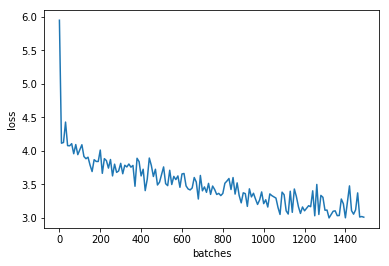




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.

Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.

"I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.

His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.

Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.

"She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.

"It's not an easy thing 

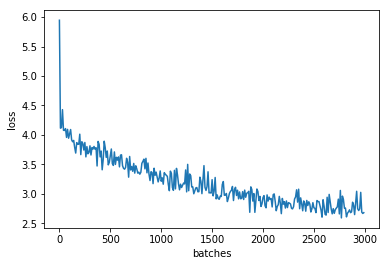




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.

Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.

"I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.

His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.

Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.

"She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.

"It's not an easy thing 

KeyboardInterrupt: 

In [23]:
batch = 0
batches = []
losses = []
for epoch in np.arange(EPOCHS):
    print('\nEpoch %d:' % epoch)
    for start_file_idx in tqdm_notebook(np.arange(0, STORIES_TO_TRAIN, BATCH_SIZE)):
        end_file_idx = min(start_file_idx+BATCH_SIZE, STORIES_TO_TRAIN)

        # get story and summary strings
        stories = []
        summaries = []
        for filename in story_files[start_file_idx:end_file_idx]:
            f = open(STORIES_DIR+filename, 'r')
            combo = f.read()
            splt = combo.split('@highlight')

            story = splt[0].replace('(CNN)', '')
            stories.append(story)

            summary = '. '.join(splt[1:]).replace('\n', '')
            summaries.append(summary)

            f.close()
        N = len(stories)

        # embed stories
        stories_embeddings = np.zeros(
            (N, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
            dtype='float32'
        )
        for i, story in enumerate(stories):
            story_token_ids = sp.EncodeAsIds(story)
            for j, token_id in enumerate(story_token_ids):
                if j < MAX_STORY_TOKENS_TO_CONSIDER:
                    stories_embeddings[i, j, token_id] = 1.
                else:
                    break       
        
        # embed summaries
        summaries_embeddings_input = np.zeros(
            (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
            dtype='float32'
        )   
        summaries_embeddings_target = np.zeros(
            (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
            dtype='float32'
        )
        for i, summary in enumerate(summaries):
            summary_token_ids = sp.EncodeAsIds(summary)
            for j, token_id in enumerate(summary_token_ids):
                if j <= MAX_SUMMARY_TOKENS_TO_CONSIDER:
                    if j < MAX_SUMMARY_TOKENS_TO_CONSIDER:
                        summaries_embeddings_input[i, j, token_id] = 1.
                    if j > 0:
                        summaries_embeddings_target[i, j-1, token_id] = 1.
                else:
                    break

        # update model
        model.train_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
        if (batch % BATCHES_PER_LOSSCALC) == 0:
            batches.append(batch)
            loss = model.test_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
            losses.append(loss)
        batch += 1
    
    
    # save model:
    model.save(MODEL_NAME+'.h5')
    
    # plot loss
    plt.plot(batches, losses)
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    plt.close()
    
    # spot check performance
    for i in range(2):
        to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE)
        generated_summary, candidate_sentences = get_summary(to_summarize, BEAM_K)
        print('\n\n')
        print('Story:')
        print(stories[i])
        print('\nActual Summary:')
        print(summaries[i])
        print('\nGenerated Summaries:')
        for candidate in candidate_sentences[-min(5, BEAM_K):]:
            print('\n')
            print(sp.DecodeIds(candidate['encoding']))

## Spot Check Performance

In [ ]:
for i in range(2):
    to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE)
    generated_summary, candidate_sentences = get_summary(to_summarize, BEAM_K)
    print('\n\n')
    print('Story:')
    print(stories[i])
    print('\nActual Summary:')
    print(summaries[i])
    print('\nGenerated Summaries:')
    for candidate in candidate_sentences[-min(5, BEAM_K):]:
        print('\n')
        print(sp.DecodeIds(candidate['encoding']))